<img src="../strathclyde_banner.png" alt="University of Strathclyde" width="50%" align="left">

# Digital Filter Design

## Table of Contents

* [1. Introduction](#introduction)
* [2. FIR Filters](#fir-filters)
* [3. Types of Frequency Responses](#frequency-responses)
* [4. Filter Characteristics](#filter-characteristics)
    * [4.1 Magnitude Response](#magnitude-response)
    * [4.2 Phase Response](#phase-response)
* [5. Filter Design Methods](#filter-design-methods)
    * [Window Method](#window-method)
    * [Parks-McClellan Algorithm](#parks-mcclellan)
    * [Least Squares Method](#least-squares)
* [6. Conclusion](#conclusion)

## References

[1] - T.W. Parks and C.S. Burrus, "Digital Filter Design", Wiley, 1987.

[2] - J.G. Proakis and D.G. Manolakis, "Digital Signal Processing", Prentice-Hall, 1996.

## 1. Introduction <a class="anchor" id="introduction"></a>

Digital filters are a key element of Digital Signal Processing (DSP) and they are implemented using only Multiply-Add (MAC) operations, and delays. Their role in a DSP system is to attenuate certain bands of frequencies within a signal, while letting the other frequency bands pass through unchanged. 

There are two main algorithms for digital filters, Finite Impulse Response (FIR) and Infinite Impulse Response (IIR). Typically, FIR filters are preferred for many applications because they are more stable and can easily be constrained to achieve a linear phase response (more on this later). For these reasons, we will concentrate on the design of FIR filters only.

There are many FIR filter design tecniques available to DSP engineers, all producing filters with varying characteristics. In this notebook we will look at some of the most common techniques, and understand the differences between them.

## 2. FIR Filters <a class="anchor" id="fir-filters"></a>

An FIR filter convolves an input signal with an impulse response, and can be mathematically expressed as:

$y(k) = \sum_{n=0}^{N-1} h_n x(k-n)$

where $x$ is the input signal, $k$ is the sample index, and $h$ expresses the samples (coefficients) of the impulse response.

Impulse responses change the shape of a signal which cause certain frequencies to be attenuated when convolved together. When we design filters, the output of the algorithms we use are the coefficients of these impulse responses.

An impulse response is a time-domain representation. It would be extremely difficult (if not impossible) to determine the effect an impulse response would have on an input signal by simply looking at it.

For instance, Figure 1 shows two impulse responses; one attenuates high frequencies, the other attenuates low frequencies. Can you tell which one is which? If so, can you tell which frequencies each one will pass and which it will attenuate? And by how much?

<figure>
<img src='./images/filter_impulse_responses.svg' height='auto' width='auto'/>
    <figcaption><b>Figure 1: Two filter impulse responses.</b></figcaption>
</figure>

For this reason it is much better to think about a filter in terms of its **frequency** response, rather than its impulse response.

## 3. Types of Frequency Responses <a class="anchor" id="frequency-responses"></a>

Filters are often classed into four different frequency responses: Low Pass, High Pass, Band Pass, and Band Stop, signifying which frequencies the filter allows to "pass" through unchanged, and which frequencies are attenuated.

Figure 2 shows us an example of each of the four frequency responses. In these examples, the cutoff frequency (the point at which the frequencies of an input signal change from being either passed or attenuated) is around the centre of the frequency band. In practice, the cutoff frequency can be at any arbitrary point.

<figure>
<img src='./images/filter_responses.svg' height='auto' width='auto'/>
    <figcaption><b>Figure 2: The four filter frequency responses.</b></figcaption>
</figure>

The motivation for filtering is to alter the frequency composition of a signal, where it is necessary to attenuate unwanted frequencies. Some examples are:

- A low pass filter for anti-imaging in the interpolator of a radio transmitter, or anti-aliasing within the decimator of a receiver.
- A high pass filter to extract a particular channel from a demodulated multiplex of radio signals.
- A bandpass filter to extract a modulated radio signal from spectrum sampled at Intermediate Frequency (IF) rates.
- A bandstop filter to remove a narrowband interferer.

## 4. Filter Characteristics <a class="anchor" id="filter-characteristics"></a>

When we design filters it is usually done to a specification where a particular frequency response is required.Therefore based on a given specification, a designer will appropriately generate a digital filter.

Figure 2 shows the frequency response of the four most common types of filters, in terms of their magnitude (as opposed to amplitude).

A filter is usually characterised by two different responses: magnitude response and phase response. The magnitude response determines the absolute change in gain that the signal experiences over its entire frequency range. The phase response determines the shift in phase that the signal experiences at specific frequencies.

### 4.1 Magnitude Response <a class="anchor" id="magnitude-response"></a>

The magnitude response of a filter is usually described by three characteristics: **Passband Ripple**, **Stopband Attenuation**, and **Transition Bandwidth**, as shown for the example of a high pass filter in Figure 3. *Note* that it is common to display the y-axis of the magnitude response in dB in order to better understand how the filter behaves in the stopband.

<figure>
<img src='./images/filter_characteristics.svg' height='auto' width='auto'/>
    <figcaption><b>Figure 3: Characteristics of a filter's magnitude response.</b></figcaption>
</figure>

- **Passband ripple** measures the amplitude of the oscillations in the passband, usually measured in dB. The larger the amplitude of these ripples, the more distortion will occur in the passband.
- **Stopband attenuation** is the measure of how much the unwanted frequencies are attenuated. Again, this is usually given in dB, and is measured from the highest peak (sidelobe) in the stopband. The attenuation required can differ greatly dependent on the application, from as little as 20dB for some audio applications, to over 80dB for radio systems. 
- **Transition bandwidth** is the frequency range between the passband and the stopband. When the number of coefficients required for a filter is constrained, the transition bandwidth can have a big effect on passband ripple and stopband attenuation. The smaller the transition bandwidth, the larger the passband ripple and the lower the stopband attenuation will be. 

The ideal filter would have zero passband ripple, infinite stopband attenuation, and a transition bandwidth that is infinitesimally small. Its frequency response would look like the rectangular function, such as the one shown in Figure 4.

<figure>
<img src='./images/ideal_filter_response.svg' height='auto' width='auto'/>
    <figcaption><b>Figure 4: An ideal high pass filter frequency response.</b></figcaption>
</figure>

Unfortunately, it is not possible to implement an ideal filter, therefore we must make some compromises in the filter design process. One way of improving the quality of a filter is to increase the filter length.

Let's look at a very simple filter and see how changing the filter length can change the frequency response of a low pass filter. We will be using the ```firwin2``` function (from the ```signal``` class from ```SciPy```) to design this filter. How this design method works will be explained later in the notebook but, for now, we will skip over the details.

First we need to import the Signal library.

In [1]:
from scipy import signal

We can now define the filter parameters.

In [2]:
fc = 0.2 # normalised cutoff frequency (% of Nyquist)
N = 101 # length of filter (number of coefficients)

freq = [0, fc, fc, 1] # frequency sampling points of filter (up to Nyquist)
gain = [1, 1, 0, 0] # filter gains at frequency sampling points

The ```freq``` and ```gain``` variables are lists that describe our *ideal* frequency response.

```freq``` tells the filter design function which frequencies we are interested in. The frequencies we give are normalised to the Nyquist frequency (half the sample rate), so 0.2 here is 20% of Nyquist, or 10% of the full sample rate.

```gain``` tells the function what amplitudes we want ```freq``` to have. For a low pass filter that means full gain up to the cutoff frequency, and zero gain for all frequencies after (we use ```fc``` twice in ```freq``` in order to get the tightest transition band possible).

We then input these parameters to ```firwin2``` to create the filter.

In [3]:
lpf = signal.firwin2(N, freq, gain)

Now to get the frequency response of the filter we use the FFT. We'll be doing this a few times so we will make a helper function to make things easier. The Python library ```Numpy``` includes an FFT algorithm we can use.

In [4]:
import numpy as np

def get_normalised_fft(x, NFFT):
    X = np.fft.fft(x,NFFT)
    return X/max(abs(X)) # normalise

In [5]:
NFFT = 4096 # FFT length
nf = np.linspace(0, 2, NFFT)

lpf_fft = get_normalised_fft(lpf, NFFT)
lpf_fft_db = 20*np.log10(abs(lpf_fft)) # convert to dB

Then we can then use the Python plotting library ```matplotlib``` to plot our magnitude response.

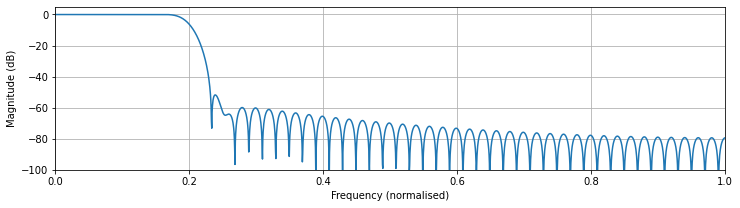

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.xlabel('Frequency (normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
plt.ylim(-100,5)
plt.grid(True)

plt.plot(nf, lpf_fft_db)
plt.show()

We can see from the settings we used, the stopband attenuation is approximately 50dB, while the transition bandwidth is about 2.5% of the sample rate (much higher than the ideal band we asked for). The passband ripple is too small to see in this plot, so we can use the *ylim* parameter to zoom in for us in the next cell.

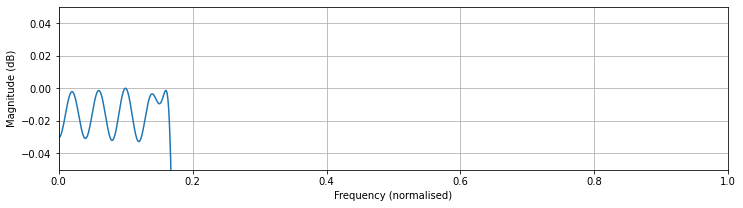

In [7]:
plt.figure(figsize=(12,3))
plt.xlabel('Frequency (normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
plt.ylim(-0.05,0.05)
plt.grid(True)

plt.plot(nf, lpf_fft_db)
plt.show()

We can see from this view that the maximum passband ripple is approximately 0.03dB, which is very low. It may not always be this low though so it is always important to check to see if it is within acceptable levels.

Try changing the filter length to see how this affects the frequency response. You should notice the frequency response improving as the filter length increases.

### 4.2 Phase Response <a class="anchor" id="phase-response"></a>

For certain applications, the phase response of a filter is an equally important factor. In general, a filter will change the phase of any signal passing through it. Depending on the filter design, the phase will change by different amounts at different frequencies. And, because a change in phase is a delay in time, it will not affect the magnitude response of a signal, but rather the signal in the time-domain.

Changes in phase are less important for things like audio applications where it may be difficult for the human ear to perceive them, but can be critical for radio applications where the phase of a signal is used to represent information.

FIR filters are preferred for phase-sensitive applications because they are easily constrained to achieve a linear phase response. If a filter exhibits linear phase it means that the shift in phase, relative to each frequency, changes at a constant rate (i.e linearly). Conversely, for non-linear phase filters the phase shift will not be constant between frequencies, hence distorting the shape of the time-domain signals passing through the filter.

An FIR filter will exhibit linear phase if its impulse response is even or odd symmetrical, or even or odd anti-symmetrical around its centre point. This results in four types of linear phase FIR filters, as shown in Figure 5.

<figure>
<img src='./images/linear_phase_impulses.svg' height='auto' width='auto'/>
    <figcaption><b>Figure 5: The four types of linear phase impulse responses.</b></figcaption>
</figure>


Each linear phase filter type has its own characteristics and are used for various applications. Generally, Type I and Type II are the most commonly used. Type I filters (odd number of coefficients and symmetric) are the most universal and can be used for low pass, high pass, bandpass, and bandstop responses. Type II filters (even number of coefficients and symmetric) are more restrictive where, under most circumstances, only low pass and bandpass responses are possible.

We can retrieve the phase response from our FFT using ```numpy```. You will notice from the code below that we unwrap the phase response after calculating it. Unwrapping adds 2$\pi$ to each subsequent angle, allowing us to view the true linearity of the phase response when plotting.

In [8]:
lpf_phase = np.unwrap(np.angle(lpf_fft))

Often, the phase response of a filter is plotted alongside its frequency response. This allows the phase response in the passband and stopband to be clearly identified.

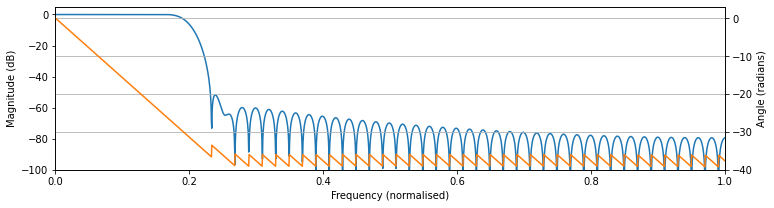

In [9]:
plt.figure(figsize=(12,3))

plt.xlabel('Frequency (normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
plt.ylim(-100,5)
plt.plot(nf, lpf_fft_db)

plt.twinx()
plt.ylabel("Angle (radians)")
plt.axis('tight')
plt.xlim(0,1)
plt.ylim(np.floor(min(lpf_phase[0:int(len(lpf_phase)/2)])) ,3)
plt.plot(nf, lpf_phase, color='tab:orange')

plt.grid(True)
plt.show()

As we can see from the plot, the phase response throughout the passband changes linearlly as the frequency increases. 

You will also notice that there are sudden discontinuities in the stopband which match up with the edges of the sidelobes. While it is beyond the scope of this notebook to discuss why this happens in detail, you should note that it is typical to see this behaviour when displaying the phase response in this form.

## 5. Filter Design Methods <a class="anchor" id="filter-design-methods"></a>

Now we understand what a filter is and how to measure its performance, we can now move onto how to design the filter and retrieve the coefficients.

There are a number of algorithms available to engineers for generating filter coefficients. Each have their own quirks and some are better than others.

In this notebook we discuss three of the more common filter design techniques: the Window Method, the Parks-McClellan Algorithm, and the Least Squares Method.

### 5.1 Window Method <a class="anchor" id="window-method"></a>

The Window Method is a popular way to design filters as it is fast, easy to implement, and generally achieves adequate results. The method simply *windows* an ideal impulse response $h_d(n)$ by multiplying it by a window function $w(n)$:

$h(n) = w(n).h_d(n)$

The ideal impulse response will be infinite in length so is not practical to implement it. Instead, we have to truncate it to a length that is suitable to the application (the longer the filter, the more calculations are required, and the longer the delay). When we truncate the ideal impulse response though, it causes the filter to behave in undesirable ways. Truncating the ideal impulse response is analogous to multiplying it by a rectangular window.

It is for this reason, windows other than the rectangular window are used. Typically, good windows display a tapered response towards zero which helps *smooth* the edges of the truncated impulse response. ```Numpy``` is able to generate a number of the most popular windows, known as General Cosine Windows.

In [10]:
w_hamming = np.hamming(N)
w_hann = np.hanning(N)
w_blackman = np.blackman(N)

We can plot the windows together to understand how they differ.

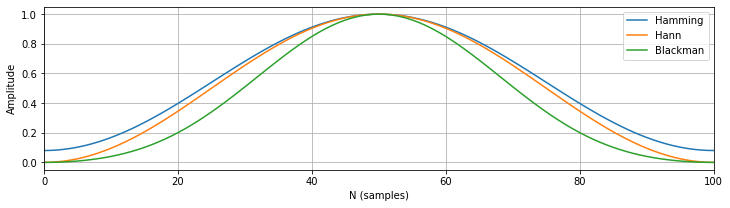

In [11]:
# Types of windows

plt.figure(figsize=(12,3))
plt.plot(w_hamming, label="Hamming")
plt.plot(w_hann, label="Hann")
plt.plot(w_blackman, label="Blackman")
plt.xlim(0,101-1)
plt.xlabel("N (samples)")
plt.ylabel("Amplitude")

plt.legend()
plt.grid(True)
plt.show()

You will notice that all three windows have a taper at the ends which tend towards zero (note that the Hamming window does not actually reach zero, but gets close). As we mentioned earlier, this helps smooth out our truncated ideal impulse response.

So how to we get the ideal filter response for the type of filter we want?

For a low pass filter, the ideal impulse response is the well-known Sinc function:

$h_d(n) = sinc(f_c n) = \frac{sin(2\pi f_c n)}{\pi n}$.

Where $f_c$ is our desired cutoff frequency and, for a truncated, odd-length Sinc, $-\frac{N-1}{2} < n \leq \frac{N-1}{2}$

This means, for lowpass, we can just calculate the Sinc and simply multiply it by our desired window, and retrieve our filter coefficients.

In [12]:
n = np.arange(-(N-1)/2,(N-1)/2+1)
fc = 0.3 # normalised cutoff frequency (% of Nyquist)
hd_n = np.sinc(fc*n)

h_n = hd_n * w_hamming

If we plot $h_d(n)$ against $h(n)$ we can see how the windowing affects the Sinc function.

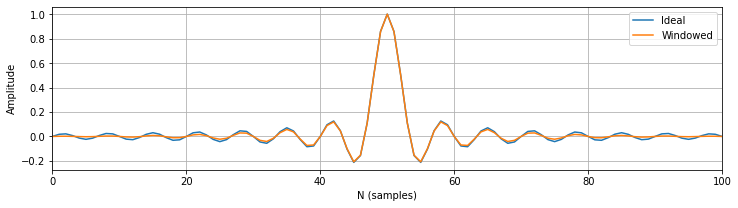

In [13]:
plt.figure(figsize=(12,3))
plt.plot(hd_n, label="Ideal")
plt.plot(h_n, label="Windowed")
plt.grid(True)
plt.xlim(0,len(h_n)-1)
plt.ylabel("Amplitude")
plt.xlabel("N (samples)")
plt.legend()
plt.show()

We can see that, as expected, our window smooths out the Sinc pulse. It is much more informative though to compare them in the frequency domain.

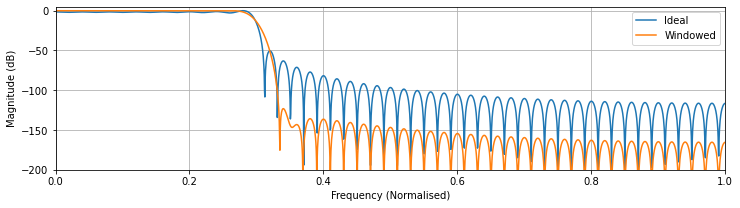

In [14]:
hd_n_fft = 20*np.log(abs(get_normalised_fft(hd_n, NFFT))) # get the magnitude in dB
h_n_fft = 20*np.log(abs(get_normalised_fft(h_n, NFFT)))

nf_norm = np.linspace(0,2,NFFT)

plt.figure(figsize=(12,3))
plt.xlabel('Frequency (Normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
plt.ylim(-200,5)
plt.grid(True)

plt.plot(nf_norm, hd_n_fft, label="Ideal")
plt.plot(nf_norm, h_n_fft, label="Windowed")

plt.legend()
plt.show()

By plotting the frequency responses we can better see how the windowing affects the filter. 

The windowed filter displays much better stopband attenuation than our *ideal* Sinc, but has a larger transition bandwidth.

By running the next cell, we can zoom in and see the passband ripple has been greatly reduced as well.

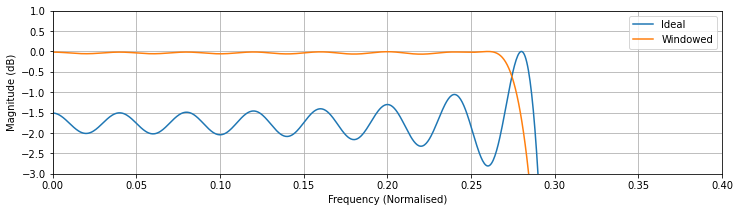

In [15]:
plt.figure(figsize=(12,3))
plt.xlabel('Frequency (Normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,0.4)
plt.ylim(-3,1)
plt.grid(True)

plt.plot(nf_norm, hd_n_fft, label="Ideal")
plt.plot(nf_norm, h_n_fft, label="Windowed")

plt.legend()
plt.show()

Each window has its own characteristics and the differences between them are usually a trade-off between stopband attenuation and transition bandwidth. You can try out the others by changing the window that $h_d(n)$ is multiplied by, and then run the previous cells again. You should see that the Blackman Window has the best stopband attenuation, whereas the Hamming has the best transition bandwidth. The Hann window is somewhere in between.

As the Sinc pulse is purely for low pass filters, how do we calculate the impulse response for filters with other responses (e.g. bandpass)?

As we've seen before, to retrieve a filter's frequency response, we can use the FFT on the impulse response. It is then logical that we can retrieve the impulse response by doing the inverse transform, the IFFT. 

This method is called Frequency Sampling filter design due to the fact that we *sample* an ideal frequency response, and then convert these samples into time-domain coefficients using the IFFT. We can then multiply this impulse response with a window to retrieve our desired filter.

Instead of building the function to do this ourselves, the ```Signal``` library contains the ```firwin2``` function that can do this for us. 

In [16]:
freq = [0, 0.4, 0.4, 0.6, 0.6, 1]
gain = [1, 1, 0, 0, 1, 1]
N = 101

h_wm = signal.firwin2(N, freq, gain, window='blackman')

As we saw when calculating the low pass filter at the beginning of the notebook, ```firwin2``` takes a list of frequencies and gains, which correspond to our desired frequency response.

In the cell above, we require a bandstop filter where there is zero gain between 40% and 60% of the Nyquist rate, and unity gain everywhere else. The first argument is the number of filter weights we want, and the last argument is telling the function what window to use.

We can then convert the filter back into the frequency domain to check the quality of the filter that ```firwin2``` produced.

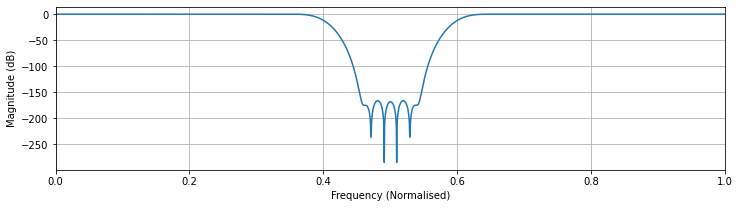

In [17]:
h_wm_fft = 20*np.log(abs(get_normalised_fft(h_wm, NFFT)))

nf_norm = np.linspace(0,2,NFFT)

plt.figure(figsize=(12,3))
plt.xlabel('Frequency (Normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
# plt.ylim(-300,5)
plt.grid(True)

plt.plot(nf_norm, h_wm_fft)

plt.show()

The filter looks good, with a stopband attenuation of around 160dB, but the transition bandwidth is quite large. How can we improve the filter? Try changing the filter length, ```N```, as well as the windows to see how the frequency response changes (remember that for a bandstop response, ```N``` must be an odd value! Python will raise an error if you try to create a bandstop filter with an even number of coefficients.)

There are a number of windows available to try including ```hann```, ```rectangular```, and ```blackman```. Details on more windows can be found in the Signal documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window).

The major drawback of the Window Method is that you have very little control over the transition bandwidth because the inherent shape of the window's frequency response over this region takes precedence. Luckily, there are a number of different methods to design filters which give you much more control over the resultant frequency response.

### 5.2 Parks-McClellan Algorithm <a class="anchor" id="parks-mcclellan"></a>

The Parks-McClellan algorithm is probably the most widely known and used filter design method. It uses the Remez Exhange algorithm and Chebyshev Approximation to design an optimal filter that minimises the error between the desired (ideal) response and the actual (achievable) response.

The first and last stages of the algorithm are actually identical to the Frequency Sampling method we discussed earlier. You start with a desired frequency response, and end by using the inverse Fourier transform to retrieve the coefficients. 

The middle section of the algorithm calculates a best guess approximation of the desired filter and calculates the maximum error over the entire response. If the error is too large then another guess is made and the algorithm repeats. This goes on until the maximum error has been minimised to an appropriate value.

You may recognise this as an optimisation technique, and that is because it is! The benefit of using this type of algorithm is that you have significantly more control over the frequency response than you do with the Window Method, most notably, the transition bandwidth.

A major limitation of this technique though is that it requires convergence (e.g. the error must be continuously minimised). Under certain conditions the error will fluctuate wildly and the algorithm will never find an optimal solution, causing the filter design routine to run ad infinitum. 

We can avoid this by adding constraints to the algorithm, for instance by setting a maximum number of iterations to compute, but the resultant filter may not be suitable. Another option is to reduce the constraints on the transition bandwidth by making it wider; again, this may result in an undesirable filter. For these reasons it is always best to check the quality of the filter before applying it to your system.

SciPy also includes the Parks-McClellan algorithm in its ```Signal``` class: ```remez```. We can use this to design a similar bandpass filter as we did with the Window Method.

In [18]:
N = 101
tb = 0.01 # transition bandwidth (%)
freq = [0, 0.20-tb, 0.20, 0.3, 0.30+tb, 0.5]
gain = [1,0,1]

h_pm = signal.remez(N, freq, gain)


The inputs to ```remez``` are very similar to ```firwin2``` with some subtle differences. Firstly, the list of frequencies we choose are given in relation to the sample rate, not the Nyquist rate as was the case before. Secondly, the list of gains must be half the length of the list of frequencies. This gives a more general shape to the filter. For example ```[1,0]``` for low pass, ```[0,1]``` for high pass, and ```[0,1,0]``` for bandpass responses. 

Finally, it is recommended to include a transition bandwidth in the list of frequencies to allow more opportunity for the algorithm to converge. ```remez``` will usually warn you if it doesn't think the algorithm will converge with the given settings. Here we have chosen a transition bandwidth of 1% of the sample rate.

We can now look at the frequency response to check the quality of the filter.

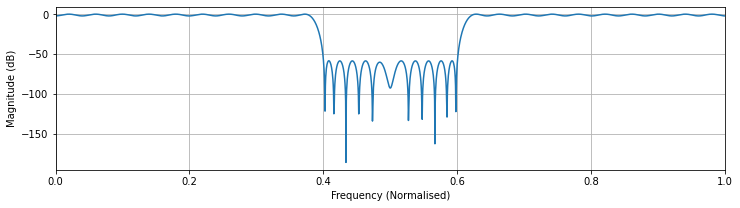

In [19]:
h_pm_fft = 20*np.log(abs(get_normalised_fft(h_pm, NFFT)))

nf_norm = np.linspace(0,2,NFFT)

plt.figure(figsize=(12,3))
plt.xlabel('Frequency (Normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
# plt.ylim(-100,5)
plt.grid(True)

plt.plot(nf_norm, h_pm_fft)

plt.show()

The frequency response shows that the transition bandwidth is much tighter than what was achieved with the Window Method, but the stopband attenuation is much lower and there is much more ripple in the passband. 

Try changing the value of ```N``` and the transition bandwidth, ```tb```, to see how this affects the filter response. These changes can be made in the first code cell in this section.

As we mentioned earlier, although the use of the optimisation technique to approximate the desired filter gives us greater control over the frequency response, the problem of convergence can be a limiting factor when using the Parks-McClellan algorithm. 

Another common method of filter design that uses an approximation method to design the filter, but removes the need for an iterative algorithm, is the Least Squares Method.

### 5.3 Least Squares Method <a class="anchor" id="least-squares"></a>

The Least Squares Method allows the design of filters by minimising the *squared* error between the desired and actual frequency response. Unlike the Parks-McClellan algorithm, it avoids the use of iteration by solving a system of linear equations instead.

By avoiding iteration there are no concerns regarding convergence, although for long length filters, the size of the matrices required can sometimes be the limiting factor.

SciPy's ```Signal``` class also has a function for generating filters using Least Squares: ```firls```. We can use this function to design a similar bandpass filter to those generated previously.

In [20]:
tb = 0.01 # transition bandwidth (%)
freq = [0, 0.40-tb, 0.4, 0.60, 0.60+tb, 1]
gain = [1, 1, 0, 0, 1, 1]
N = 101

h_ls = signal.firls(N, freq, gain)


As with ```firwin2``` and ```remez```, ```firls``` takes the filter length, N; and a list of frequencies and gains that describe the frequency response, as input parameters. Like ```firwin2```, ```firls``` lists the frequencies up to the Nyquist rate (instead of up to the sample rate), and the list of gains is of the same length.

```firls``` also allows the transition bandwidth to be included or omitted as required. This makes the ```firls``` method much more flexible than either of the previous methods.

We can now look at the frequency response to check the quality of the filter.

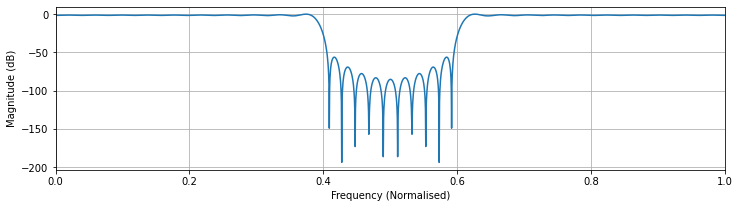

In [21]:
h_ls_fft = 20*np.log(abs(get_normalised_fft(h_ls, NFFT)))

nf_norm = np.linspace(0,2,NFFT)

plt.figure(figsize=(12,3))
plt.xlabel('Frequency (Normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
plt.grid(True)

plt.plot(nf_norm, h_ls_fft)

plt.show()

As we can see from the frequency response, the Least Squares Method gives us a stopband attenuation similar to the Parks-McClellan algorithm, but with much less ripple in the passband. Try changing the filter length and transition bandwidth to see how this changes the filter.

## 6. Conclusion <a class="anchor" id="conclusion"></a>

This notebook has taken you through the basics of filter design. We initially looked at filter characteristics, describing the magnitude and phase responses to understand how a filter changes a signal. We then went on to describe three popular filter design methods used to generate filter coefficients, the Window, Parks-McClellan, and the Least Squares methods.

Each method has its pros and cons. The Window Method is fast, easy to compute, and produces filters with frequency responses that are easy to predict; while the Parks McClellan and Least Squares algorithms give much more control over a filter's frequency response, but can take longer to compute and it may be difficult to achieve a desired response if the constraints are too restrictive.

There is no *best* method for designing filters, and it depends on a number of factors and trade-offs. It is up to the engineer to decide which is best for a given application.